## mlbotのチュートリアル

前提

- 研究の足がかりとなるもの
- そのままでは儲からない
- 執筆中

改良のポイント

- 執行の改善 (y計算に使う指値価格などを工夫すると良いかも)
- CVの改善 (厳密にリークを防いだり、ハイパーパラメータチューニング用にnested cvにするなどの改良がありえる)
- 機械学習で使われる一般的なテクニック (baggingなど)

実運用の注意点

- 含み損によるゼロカットのシミュレーションをしていない
- スケーラビリティーを調べていない (GMOコインは約定データが手に入るので、指値に刺さった出来高を調べれば、スケーラビリティーを調べられる)

In [101]:
# 必要なライブラリのインポート

from collections import defaultdict
import json
import math
import os
import re
import time

import ccxt
from crypto_data_fetcher.gmo import GmoFetcher
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numba
import numpy as np
import pandas as pd
import scipy
from scipy.stats import norm, pearsonr, spearmanr, ttest_1samp, ttest_ind
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
import talib

from sklearn.ensemble import BaggingRegressor
from sklearn.linear_model import Ridge, RidgeCV, LassoCV, LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, KFold, TimeSeriesSplit
from sklearn.preprocessing import QuantileTransformer


## データを用意

以下では、例としてFTXのBTC-PERPの5分足を取得します。
データ取得用のライブラリ https://github.com/richmanbtc/crypto_data_fetcher を利用していますが、
やっていることは取引所APIを呼んでいるだけです。

## 改良ポイント

### 取引所と取引ペア選び

FTX以外の取引所やBTC-PERP以外のペアを試すと良いかもしれません。
取引ペアごとに値動きの傾向は変わります。
同じペアでも取引所ごとに値動きの傾向は変わります。

### 時間軸(足の間隔)変更

時間軸によって値動きの傾向が変わります。
学習、統計的検定などにも影響を与えます。

時間軸が短いメリット

- 値動きを予測しやすい
- サンプル数が多くなり、統計的に有意になりやすい
- サンプル数が多くなり、学習が成功しやすい

時間軸が長いメリット

- バックテストと実際の誤差が出づらい (APIや取引所の処理遅延など)
- 運用資金をスケールさせやすい

In [102]:
memory = joblib.Memory('/tmp/gmo_fetcher_cache', verbose=1)
fetcher = GmoFetcher(memory=memory)

# GMOコインのBTC/JPYレバレッジ取引 (https://api.coin.z.com/data/trades/BTC_JPY/)を取得
df = fetcher.fetch_ohlcv(
    market='BTC_JPY', # 市場のシンボルを指定
    interval_sec=15 * 60, # 足の間隔を秒単位で指定。この場合は15分足
)

# チュートリアルに再現性をもたせるために期間を指定
# 同じデータで何度も試行錯誤をすると、正しくバリデーションしていたとしても
# だんだんとデータにフィッティングしていくので、データは残しておくのがおすすめ。
# 良いのができたら、最新データも含めて試してみて、傾向が変わらなければOK。
# 本番用のモデルを学習するときは、最新データも含めて学習すると良い。
df = df[df.index < pd.to_datetime('2021-04-01 00:00:00Z')]

display(df)
df.to_pickle('df_ohlcv.pkl')

,op,hi,lo,cl,volume
timestamp,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77
...,...,...,...,...,...
2021-03-31 22:45:00+00:00,6500673.0,6515799.0,6495153.0,6501148.0,24.83
2021-03-31 23:00:00+00:00,6500548.0,6514344.0,6491034.0,6504636.0,48.64
2021-03-31 23:15:00+00:00,6505950.0,6529377.0,6491838.0,6523540.0,38.07


In [103]:
# maker手数料カラムを追加
# GMOコインは時期により手数料が違うので注意
# 定期メンテナンス時刻: https://support.coin.z.com/hc/ja/articles/115007815487-%E3%82%B7%E3%82%B9%E3%83%86%E3%83%A0%E3%83%A1%E3%83%B3%E3%83%86%E3%83%8A%E3%83%B3%E3%82%B9%E6%99%82%E9%96%93%E3%81%AB%E3%81%A4%E3%81%84%E3%81%A6%E6%95%99%E3%81%88%E3%81%A6%E3%81%8F%E3%81%A0%E3%81%95%E3%81%84
# UTCの場合は6:00-7:00
# changed_atはUTCなので注意

maker_fee_history = [
    {
        # https://coin.z.com/jp/news/2020/08/6482/
        # 変更時刻が記載されていないが、定期メンテナンス後と仮定
        'changed_at': '2020/08/05 06:00:00Z',
        'maker_fee': -0.00035
    },
    {
        # https://coin.z.com/jp/news/2020/08/6541/
        'changed_at': '2020/09/09 06:00:00Z',
        'maker_fee': -0.00025
    },
    {
        # https://coin.z.com/jp/news/2020/10/6686/
        'changed_at': '2020/11/04 06:00:00Z',
        'maker_fee': 0.0
    },
]

df = pd.read_pickle('df_ohlcv.pkl')

# 初期の手数料
# https://web.archive.org/web/20180930223704/https://coin.z.com/jp/corp/guide/fees/
df['fee'] = 0.0

for config in maker_fee_history:
    df.loc[pd.to_datetime(config['changed_at']) <= df.index, 'fee'] = config['maker_fee']

display(df)
df.to_pickle('df_ohlcv_with_fee.pkl')

,op,hi,lo,cl,volume,fee
timestamp,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,0.0
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,0.0
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,0.0
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,0.0
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,0.0
...,...,...,...,...,...,...
2021-03-31 22:45:00+00:00,6500673.0,6515799.0,6495153.0,6501148.0,24.83,0.0
2021-03-31 23:00:00+00:00,6500548.0,6514344.0,6491034.0,6504636.0,48.64,0.0
2021-03-31 23:15:00+00:00,6505950.0,6529377.0,6491838.0,6523540.0,38.07,0.0


## 特徴量エンジニアリング

以下ではテクニカル指標計算ライブラリの[TA-Lib](https://mrjbq7.github.io/ta-lib/)を利用して特徴量を作成しています。

## 改良ポイント

### 特徴量の改善

後述のrichman non-stationarity scoreが下がるような特徴量を探すと良いと思います。
以下のようなTA-Lib以外のライブラリを試すのも良いと思います。

- https://github.com/bukosabino/ta

In [104]:
def calc_features(df):
    open = df['op']
    high = df['hi']
    low = df['lo']
    close = df['cl']
    volume = df['volume']
    
    orig_columns = df.columns

    print('calc talib overlap')
    hilo = (df['hi'] + df['lo']) / 2
    df['BBANDS_upperband'], df['BBANDS_middleband'], df['BBANDS_lowerband'] = talib.BBANDS(close, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
    df['BBANDS_upperband'] -= hilo
    df['BBANDS_middleband'] -= hilo
    df['BBANDS_lowerband'] -= hilo
    df['DEMA'] = talib.DEMA(close, timeperiod=30) - hilo
    df['EMA'] = talib.EMA(close, timeperiod=30) - hilo
    df['HT_TRENDLINE'] = talib.HT_TRENDLINE(close) - hilo
    df['KAMA'] = talib.KAMA(close, timeperiod=30) - hilo
    df['MA'] = talib.MA(close, timeperiod=30, matype=0) - hilo
    df['MIDPOINT'] = talib.MIDPOINT(close, timeperiod=14) - hilo
    df['SMA'] = talib.SMA(close, timeperiod=30) - hilo
    df['T3'] = talib.T3(close, timeperiod=5, vfactor=0) - hilo
    df['TEMA'] = talib.TEMA(close, timeperiod=30) - hilo
    df['TRIMA'] = talib.TRIMA(close, timeperiod=30) - hilo
    df['WMA'] = talib.WMA(close, timeperiod=30) - hilo

    print('calc talib momentum')
    df['ADX'] = talib.ADX(high, low, close, timeperiod=14)
    df['ADXR'] = talib.ADXR(high, low, close, timeperiod=14)
    df['APO'] = talib.APO(close, fastperiod=12, slowperiod=26, matype=0)
    df['AROON_aroondown'], df['AROON_aroonup'] = talib.AROON(high, low, timeperiod=14)
    df['AROONOSC'] = talib.AROONOSC(high, low, timeperiod=14)
    df['BOP'] = talib.BOP(open, high, low, close)
    df['CCI'] = talib.CCI(high, low, close, timeperiod=14)
    df['DX'] = talib.DX(high, low, close, timeperiod=14)
    df['MACD_macd'], df['MACD_macdsignal'], df['MACD_macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # skip MACDEXT MACDFIX たぶん同じなので
    df['MFI'] = talib.MFI(high, low, close, volume, timeperiod=14)
    df['MINUS_DI'] = talib.MINUS_DI(high, low, close, timeperiod=14)
    df['MINUS_DM'] = talib.MINUS_DM(high, low, timeperiod=14)
    df['MOM'] = talib.MOM(close, timeperiod=10)
    df['PLUS_DI'] = talib.PLUS_DI(high, low, close, timeperiod=14)
    df['PLUS_DM'] = talib.PLUS_DM(high, low, timeperiod=14)
    df['RSI'] = talib.RSI(close, timeperiod=14)
    df['STOCH_slowk'], df['STOCH_slowd'] = talib.STOCH(high, low, close, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
    df['STOCHF_fastk'], df['STOCHF_fastd'] = talib.STOCHF(high, low, close, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['STOCHRSI_fastk'], df['STOCHRSI_fastd'] = talib.STOCHRSI(close, timeperiod=14, fastk_period=5, fastd_period=3, fastd_matype=0)
    df['TRIX'] = talib.TRIX(close, timeperiod=30)
    df['ULTOSC'] = talib.ULTOSC(high, low, close, timeperiod1=7, timeperiod2=14, timeperiod3=28)
    df['WILLR'] = talib.WILLR(high, low, close, timeperiod=14)

    print('calc talib volume')
    df['AD'] = talib.AD(high, low, close, volume)
    df['ADOSC'] = talib.ADOSC(high, low, close, volume, fastperiod=3, slowperiod=10)
    df['OBV'] = talib.OBV(close, volume)

    print('calc talib vola')
    df['ATR'] = talib.ATR(high, low, close, timeperiod=14)
    df['NATR'] = talib.NATR(high, low, close, timeperiod=14)
    df['TRANGE'] = talib.TRANGE(high, low, close)

    print('calc talib cycle')
    df['HT_DCPERIOD'] = talib.HT_DCPERIOD(close)
    df['HT_DCPHASE'] = talib.HT_DCPHASE(close)
    df['HT_PHASOR_inphase'], df['HT_PHASOR_quadrature'] = talib.HT_PHASOR(close)
    df['HT_SINE_sine'], df['HT_SINE_leadsine'] = talib.HT_SINE(close)
    df['HT_TRENDMODE'] = talib.HT_TRENDMODE(close)

    print('calc talib stats')
    df['BETA'] = talib.BETA(high, low, timeperiod=5)
    df['CORREL'] = talib.CORREL(high, low, timeperiod=30)
    df['LINEARREG'] = talib.LINEARREG(close, timeperiod=14) - close
    df['LINEARREG_ANGLE'] = talib.LINEARREG_ANGLE(close, timeperiod=14)
    df['LINEARREG_INTERCEPT'] = talib.LINEARREG_INTERCEPT(close, timeperiod=14) - close
    df['LINEARREG_SLOPE'] = talib.LINEARREG_SLOPE(close, timeperiod=14)
    df['STDDEV'] = talib.STDDEV(close, timeperiod=5, nbdev=1)

    return df

df = pd.read_pickle('df_ohlcv_with_fee.pkl')
df = df.dropna()
df = calc_features(df)
display(df)
df.to_pickle('df_features.pkl')

calc talib overlap
calc talib momentum
calc talib volume
calc talib vola
calc talib cycle
calc talib stats


,op,hi,lo,cl,volume,fee,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA,...,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE,BETA,CORREL,LINEARREG,LINEARREG_ANGLE,LINEARREG_INTERCEPT,LINEARREG_SLOPE,STDDEV
timestamp,,,,,,,,,,,,,,,,,,,,,
2018-09-05 08:00:00+00:00,818724.0,818724.0,818724.0,818724.0,0.01,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:15:00+00:00,821250.0,821250.0,821250.0,821250.0,0.01,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 08:45:00+00:00,819260.0,819765.0,819260.0,819765.0,0.03,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 09:00:00+00:00,820000.0,821388.0,819500.0,819546.0,1.22,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-09-05 09:15:00+00:00,820441.0,821530.0,819646.0,820244.0,14.77,0.0,983.257246,-682.2,-2347.657246,NaN,...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,832.728623
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 22:45:00+00:00,6500673.0,6515799.0,6495153.0,6501148.0,24.83,0.0,23181.091959,3403.6,-16373.891959,24338.412269,...,0.725659,0.999646,1,0.220332,0.791673,7450.342857,-89.950005,22348.657143,-1146.024176,9888.745979
2021-03-31 23:00:00+00:00,6500548.0,6514344.0,6491034.0,6504636.0,48.64,0.0,7228.746675,1552.0,-4124.746675,24591.910992,...,0.746594,0.998346,1,0.729872,0.795980,5234.600000,-89.885707,11751.542857,-501.303297,2838.373338
2021-03-31 23:15:00+00:00,6505950.0,6529377.0,6491838.0,6523540.0,38.07,0.0,13610.327207,-3138.5,-19887.327207,16722.553326,...,0.690296,0.999724,1,0.314238,0.802666,-13763.742857,-89.932067,-2799.400000,-843.410989,8374.413604


## 学習に使う特徴量の定義

以下では学習に使う特徴量を定義しています。

In [105]:
features = sorted([
    'ADX',
    'ADXR',
    'APO',
    'AROON_aroondown',
    'AROON_aroonup',
    'AROONOSC',
    'CCI',
    'DX',
    'MACD_macd',
    'MACD_macdsignal',
    'MACD_macdhist',
    'MFI',
#     'MINUS_DI',
#     'MINUS_DM',
    'MOM',
#     'PLUS_DI',
#     'PLUS_DM',
    'RSI',
    'STOCH_slowk',
    'STOCH_slowd',
    'STOCHF_fastk',
#     'STOCHRSI_fastd',
    'ULTOSC',
    'WILLR',
#     'ADOSC',
#     'NATR',
    'HT_DCPERIOD',
    'HT_DCPHASE',
    'HT_PHASOR_inphase',
    'HT_PHASOR_quadrature',
    'HT_TRENDMODE',
    'BETA',
    'LINEARREG',
    'LINEARREG_ANGLE',
    'LINEARREG_INTERCEPT',
    'LINEARREG_SLOPE',
    'STDDEV',
    'BBANDS_upperband',
    'BBANDS_middleband',
    'BBANDS_lowerband',
    'DEMA',
    'EMA',
    'HT_TRENDLINE',
    'KAMA',
    'MA',
    'MIDPOINT',
    'T3',
    'TEMA',
    'TRIMA',
    'WMA',
])

## richman non-stationarity score (執筆中)

以下では、richman non-stationarity scoreを使い、特徴量の非定常性を測っています。
richman non-stationarity scoreはrichmanbtcが考案した非定常性の度合いを測る指標です。

特徴量の定常性の度合いが低いと、汎化性能が悪化する可能性があるので、
scoreが低くなるように特徴量エンジニアリングを行います。
0.3以下が目安です。

## 特徴量分布の定常性の度合いが低いと汎化性能が悪化する理由

特徴量分布が定常だと、未来でも同じ分布になることが期待できます。
一方、定常でないと、時刻によって特徴量分布が変わるので、
未来の特徴量分布が学習データの特徴量分布と異なる可能性があります。
その場合、学習データに無いデータを予測することになるので、
性能が劣化する可能性があります。

## richman non-stationarity scoreの計算方法

計算に必要なパラメータ: 回帰モデル、CVのfold数

1. シャッフル付きKFold CVで以下の2, 3を計算し、R2の平均をrichman non-stationarity scoreとする
2. 特徴量からサンプルインデックス(時刻でも良い)を与えられた回帰モデルで学習
3. validationデータに対して、サンプルインデックスを予測し、予測精度をR2で評価

この例では回帰モデルはデフォルトパラメータのlgbm、CVのfolds数は2を選んでいます。

## richman non-stationarity scoreの特徴量重要度

ツリー系モデルを使うと、重要度を表示できるので便利です。
重要度の高いものが定常性を劣化させていることがわかります。

## 参考リンク

- [時系列予測での特徴量選択](https://note.com/btcml/n/na4376bc5c336)
- [Kaggleで役立つAdversarial Validationとは](https://www.acceluniverse.com/blog/developers/2020/01/kaggleadversarial-validation.html)


dfは特徴量が入ったDataFrame
featuresは使う特徴量カラム名配列
重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある


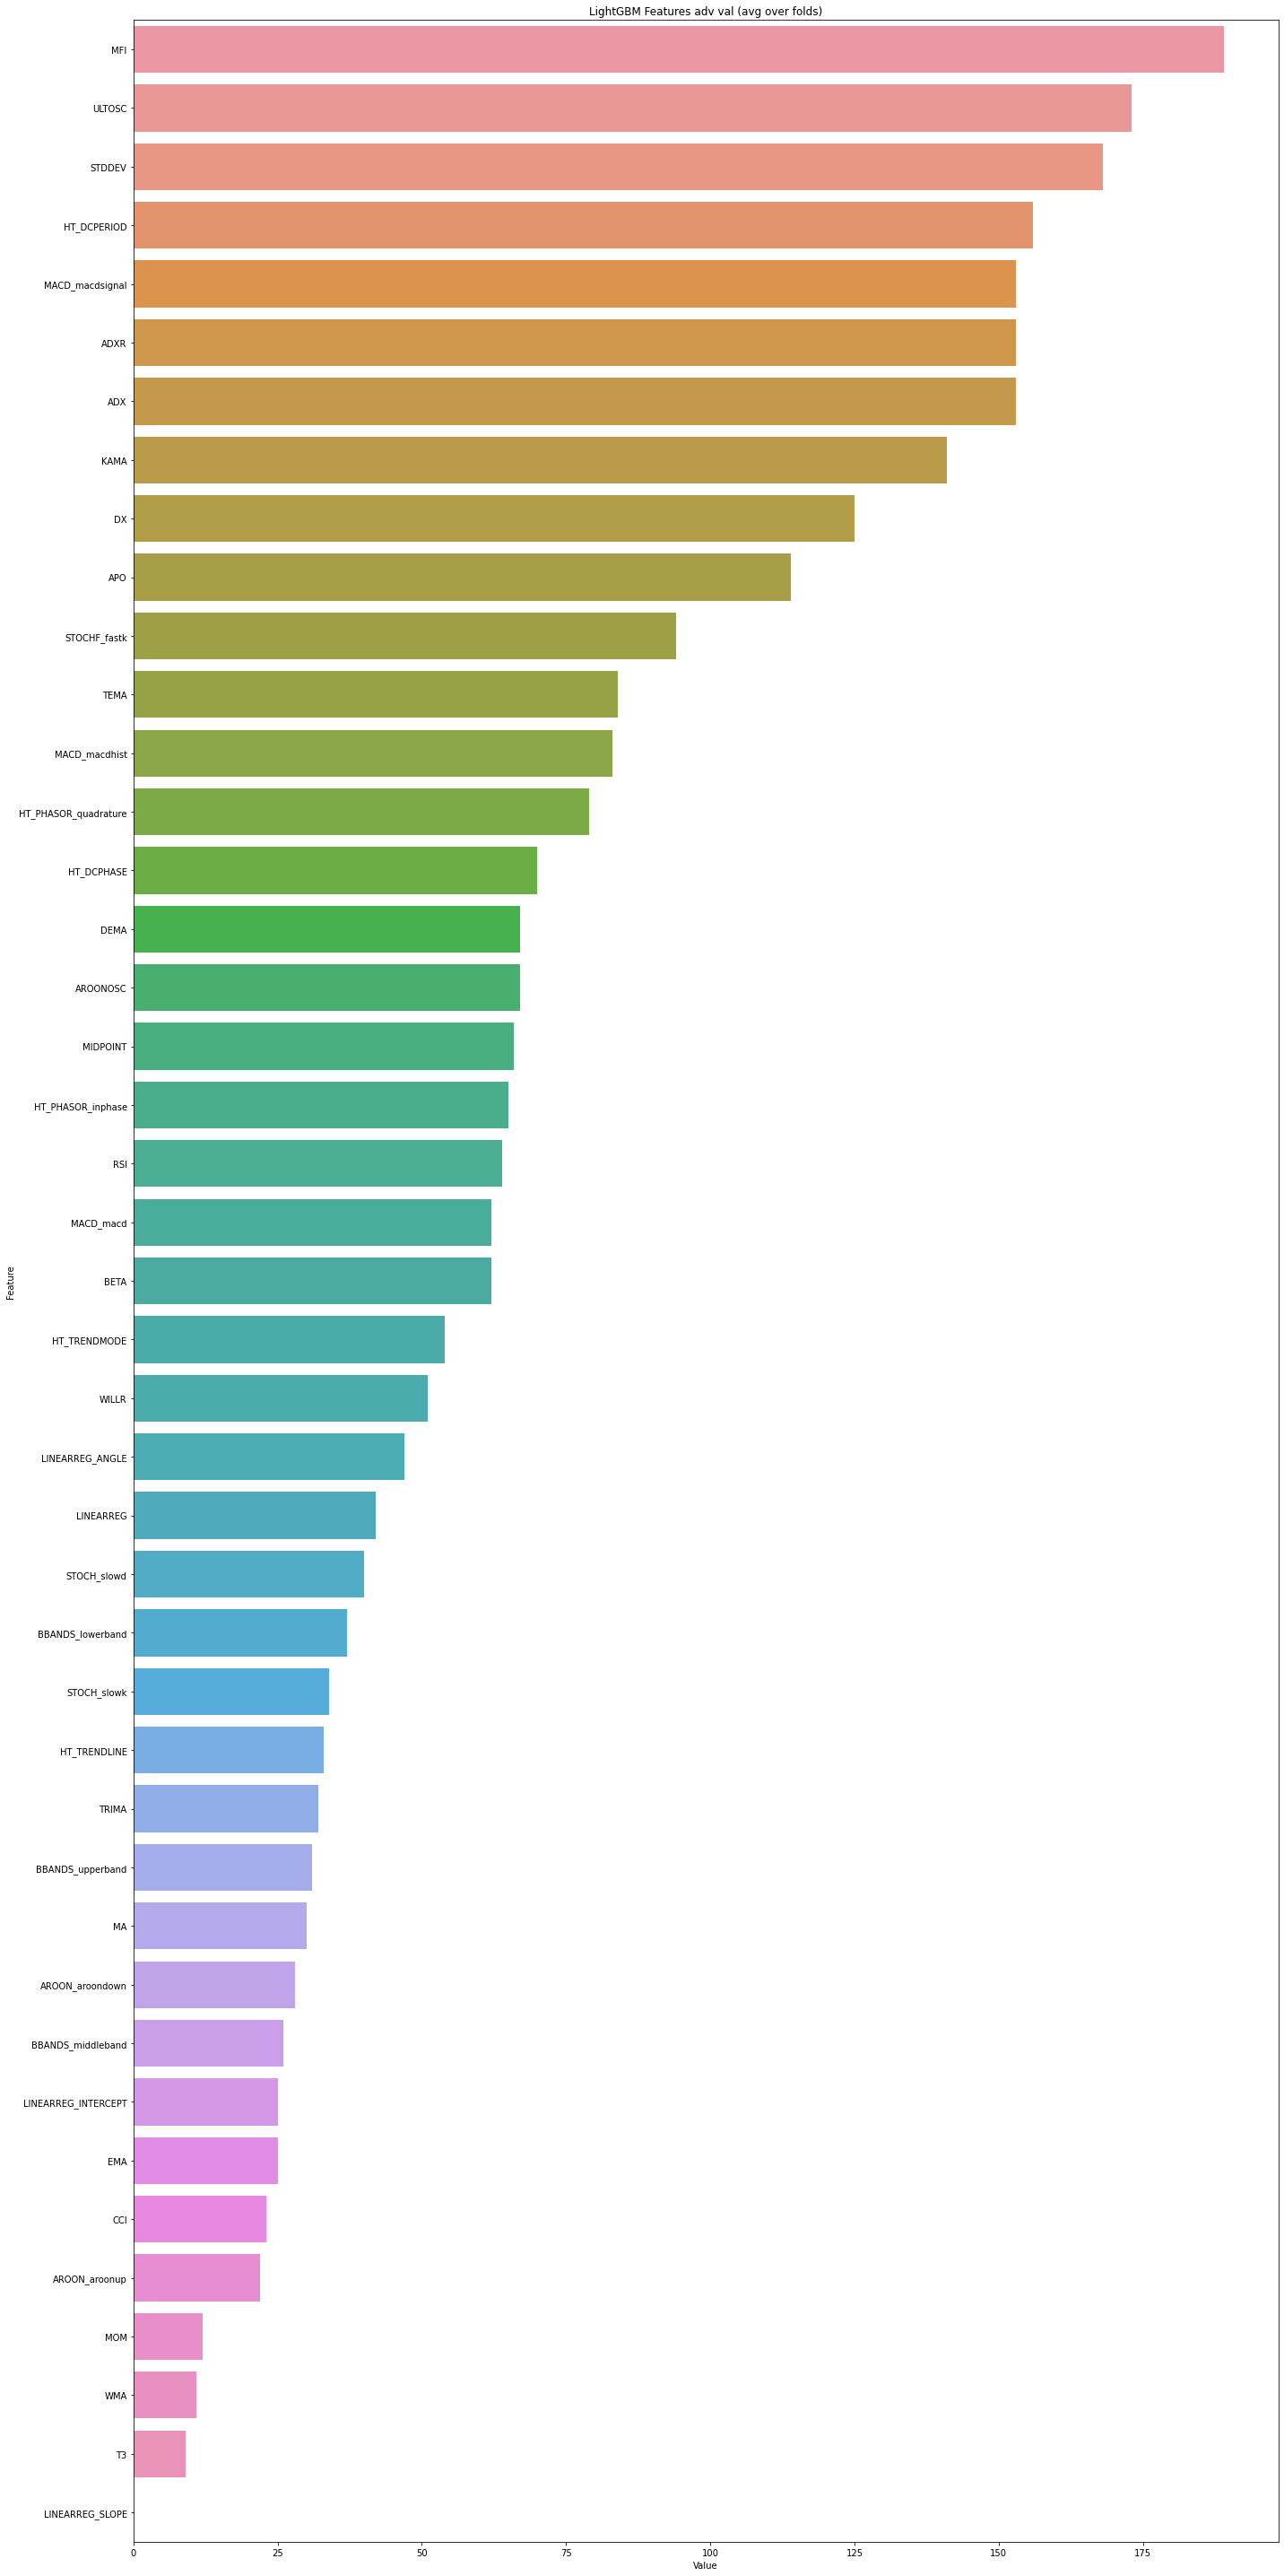

スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)
scores [0.45376922 0.45739519]
score mean, std 0.4555822076285536 0.0018129834360360864


In [106]:
df = pd.read_pickle('df_features.pkl')

print('dfは特徴量が入ったDataFrame')
print('featuresは使う特徴量カラム名配列')

print('重要度表示。重要度が高いものは汎化性能に悪影響を与える可能性がある')
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
model.fit(df[features], np.arange(df.shape[0]))
lgbm_adv_importance = model.feature_importances_
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_, features)), columns=['Value','Feature'])
plt.figure(figsize=(20, 40))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False))
plt.title('LightGBM Features adv val (avg over folds)')
plt.tight_layout()
plt.show()

print('スコア計算。スコアが高いと汎化性能が悪い可能性ある (目安は0.3以下)')
cv = KFold(n_splits=2, shuffle=True, random_state=0)
scores = cross_val_score(model, df[features], np.arange(df.shape[0]), scoring='r2', cv=cv)
print('scores', scores)
print('score mean, std', np.mean(scores), np.std(scores))

## 目的変数(y)の計算 (執筆中)

以下では目的変数(y)を計算しています。
実際の取引ルールに従ってトレードした場合に得られるリターンをyとしています。

## なにをyとするか？

コスト込みリターンをyとするのが一つの方法です。

## force entry price

calc_force_entry_priceで計算します。

## 改良のポイント

### 執行の改善


### 指値価格の計算方法

指値価格は例としてATRで計算していますが、
他の計算方法に変えると改善するかもしれません。

### コスト込みリターン以外をyとする

他にも上下を-1, 1で分類問題として解くなど、いろいろ工夫は考えられます。

## 参考リンク

- https://note.com/btcml/n/n9f730e59848c


約定確率を可視化。時期によって約定確率が大きく変わると良くない。


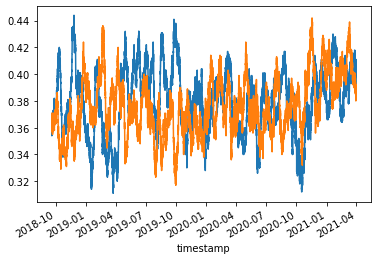

エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。


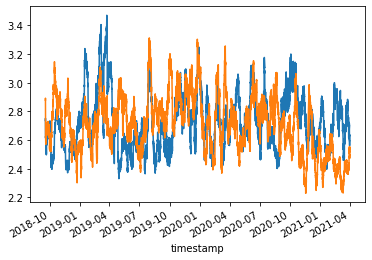

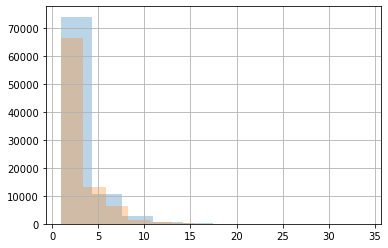

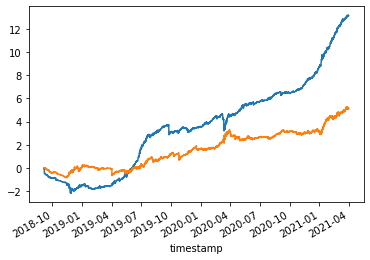

In [107]:
@numba.njit
def calc_force_entry_price(entry_price=None, lo=None, pips=None):
    y = entry_price.copy()
    y[:] = np.nan
    force_entry_time = entry_price.copy()
    force_entry_time[:] = np.nan
    for i in range(entry_price.size):
        for j in range(i + 1, entry_price.size):
            if round(lo[j] / pips) < round(entry_price[j - 1] / pips):
                y[i] = entry_price[j - 1]
                force_entry_time[i] = j - i
                break
    return y, force_entry_time

df = pd.read_pickle('df_features.pkl')

pips = 1

limit_price_dist = df['ATR'] * 0.5
limit_price_dist = np.maximum(1, (limit_price_dist / pips).round().fillna(1)) * pips

df['buy_price'] = df['cl'] - limit_price_dist
df['sell_price'] = df['cl'] + limit_price_dist

df['buy_fep'], df['buy_fet'] = calc_force_entry_price(
    entry_price=df['buy_price'].values,
    lo=df['lo'].values,
    pips=pips,
)

# calc_force_entry_priceは入力をマイナスにすれば売りに使える
df['sell_fep'], df['sell_fet'] = calc_force_entry_price(
    entry_price=-df['sell_price'].values,
    lo=-df['hi'].values, # 売りのときは高値
    pips=pips,
)
df['sell_fep'] *= -1

horizon = 1
fee = df['fee']

df['buy_executed'] = (df['buy_price'] / pips).round() > (df['lo'].shift(-1) / pips).round()
df['sell_executed'] = (df['sell_price'] / pips).round() < (df['hi'].shift(-1) / pips).round()
# 0, 1に変換
df['buy_executed'] *= 1.0
df['sell_executed'] *= 1.0

df['y_buy'] = np.where(
    df['buy_executed'],
    df['sell_fep'].shift(-horizon) / df['buy_price'] - 1 - 2 * fee,
    0
)
df['y_sell'] = np.where(
    df['sell_executed'],
    -(df['buy_fep'].shift(-horizon) / df['sell_price'] - 1) - 2 * fee,
    0
)

# バックテストで利用
df['buy_cost'] = np.where(
    df['buy_executed'],
    df['buy_price'] / df['cl'] - 1 + fee,
    0
)
df['sell_cost'] = np.where(
    df['sell_executed'],
    -(df['sell_price'] / df['cl'] - 1) + fee,
    0
)

print('約定確率を可視化。時期によって約定確率が大きく変わると良くない。')
df['buy_executed'].rolling(1000).mean().plot()
df['sell_executed'].rolling(1000).mean().plot()
plt.show()

print('エグジットまでの時間分布を可視化。長すぎるとロングしているだけとかショートしているだけになるので良くない。')
df['buy_fet'].rolling(1000).mean().plot()
df['sell_fet'].rolling(1000).mean().plot()
plt.show()
df['buy_fet'].hist(alpha=0.3)
df['sell_fet'].hist(alpha=0.3)
plt.show()

df['y_buy'].cumsum().plot()
df['y_sell'].cumsum().plot()
plt.show()

df.to_pickle('df_y.pkl')

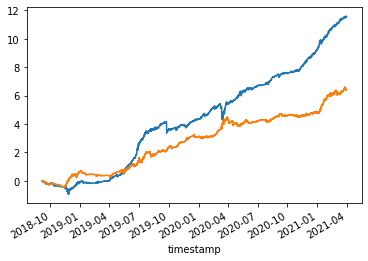

In [108]:
# 学習 + CV

df = pd.read_pickle('df_y.pkl')
df = df.dropna()

# model = RidgeCV(alphas=np.logspace(-7, 7, num=20))
model = lgb.LGBMRegressor(n_jobs=-1, random_state=1)
# model = BaggingRegressor(model, random_state=1, n_jobs=1)

# 厳密にはどちらもリーク(yに未来の区間のデータが含まれている)しているので注意
# 「ファイナンス機械学習」にCVについて詳しく書かれている

# 通常のCV
cv_indicies = KFold().split(df)
# ウォークフォワード法
# cv_indicies = TimeSeriesSplit().split(df)
                  
for train_idx2, val_idx2 in cv_indicies:
    train_idx = df.index[train_idx2]
    val_idx = df.index[val_idx2]
    model.fit(df.loc[train_idx, features], df.loc[train_idx, 'y_buy'])
    df.loc[val_idx, 'y_pred_buy'] = model.predict(df.loc[val_idx, features])
    model.fit(df.loc[train_idx, features], df.loc[train_idx, 'y_sell'])
    df.loc[val_idx, 'y_pred_sell'] = model.predict(df.loc[val_idx, features])

df = df.dropna()

df[df['y_pred_buy'] > 0]['y_buy'].cumsum().plot()
df[df['y_pred_sell'] > 0]['y_sell'].cumsum().plot()
plt.show()

df.to_pickle('df_fit.pkl')

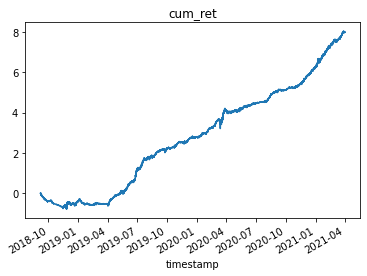

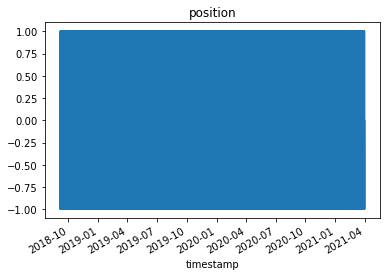

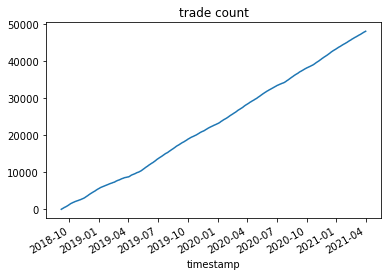

t検定
Ttest_1sampResult(statistic=7.2156014109611455, pvalue=5.412607623050697e-13)
p平均法 https://note.com/btcml/n/n0d9575882640
p mean 0.20145366838856021
error rate 0.008640615428434235
error rateが十分小さくないと有意ではない(何度も試行錯誤することを考えると1e-5以下くらい)


In [109]:
# バックテスト + 検定
# 含み損によるゼロカットをシミュレーションしていないので注意

@numba.njit
def backtest(cl=None, hi=None, lo=None, pips=None,
              buy_entry=None, sell_entry=None,
              buy_cost=None, sell_cost=None
            ):
    n = cl.size
    y = cl.copy() * 0.0
    poss = cl.copy() * 0.0
    ret = 0.0
    pos = 0.0
    for i in range(n):
        prev_pos = pos
        
        # exit
        if buy_cost[i]:
            vol = np.maximum(0, -prev_pos)
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_cost[i]:
            vol = np.maximum(0, prev_pos)
            ret -= sell_cost[i] * vol
            pos -= vol

        # entry
        if buy_entry[i] and buy_cost[i]:
            vol = np.minimum(1.0, 1 - prev_pos) * buy_entry[i]
            ret -= buy_cost[i] * vol
            pos += vol

        if sell_entry[i] and sell_cost[i]:
            vol = np.minimum(1.0, prev_pos + 1) * sell_entry[i]
            ret -= sell_cost[i] * vol
            pos -= vol
        
        if i + 1 < n:
            ret += pos * (cl[i + 1] / cl[i] - 1)
            
        y[i] = ret
        poss[i] = pos
        
    return y, poss

df = pd.read_pickle('df_fit.pkl')

df['cum_ret'], df['poss'] = backtest(
    cl=df['cl'].values,
    buy_entry=df['y_pred_buy'].values > 0,
    sell_entry=df['y_pred_sell'].values > 0,
    buy_cost=df['buy_cost'].values,
    sell_cost=df['sell_cost'].values,
)

df['cum_ret'].plot()
plt.title('cum_ret')
plt.show()

df['poss'].plot()
plt.title('position')
plt.show()

df['poss'].diff(1).abs().dropna().cumsum().plot()
plt.title('trade count')
plt.show()

print('t検定')

x = df['cum_ret'].diff(1).dropna()
print(ttest_1samp(x, 0))

print('p平均法 https://note.com/btcml/n/n0d9575882640')

def calc_p_mean(x, n):
    ps = []
    for i in range(n):
        x2 = x[i * x.size // n:(i + 1) * x.size // n]
        if np.std(x2) == 0:
            ps.append(1)
        else:
            t, p = ttest_1samp(x2, 0)
            if t > 0:
                ps.append(p)
            else:
                ps.append(1)
    return np.mean(ps)

def calc_p_mean_type1_error_rate(p_mean, n):
    return (p_mean * n) ** n / math.factorial(n)

x = df['cum_ret'].diff(1).dropna()
p_mean_n = 5
p_mean = calc_p_mean(x, p_mean_n)
print('p mean {}'.format(p_mean))
print('error rate {}'.format(calc_p_mean_type1_error_rate(p_mean, p_mean_n)))
print('error rateが十分小さくないと有意ではない(何度も試行錯誤することを考えると1e-5以下くらい)')

## 良い結果が出たバックテスト例

richmanbtcが実際に使っているボットのバックテスト結果。
青色はハイパーパラメータチューニングや試行錯誤に使った期間。
青色期間とオレンジ色期間をまとめてウォークフォワードでバックテスト。

このように、全期間で右肩上がりになっていると、将来も安定する可能性が高い。
ハイパーパラメータチューニングや試行錯誤に使わないデータ(オレンジ色)を残しておくと、
フィッティングしていないかの最終チェックができるので安心。

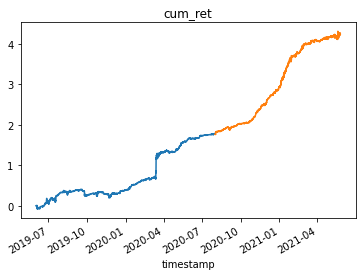
